# Visualization Project
## US Accidents dataset

<div dir=rtl>

1. האם בשל סגרים של הקורונה היה דפוס טעויות שונה מבזמן רגיל
2. האם יש ערים עם סיכוי גבוהה יותר לטעונות ואו טעונות קטלנייות יותר ? האם עיר כזאת שבה הסיכוי גבווהה יותר אבל בלי קשר לאוכלוסיה ? (לבצע נרמול לפי גודל הערים)

</div>

### Connecting to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Visualization Project/data/US_Accidents_March23_sampled_500k.csv')
# df.head()

### Adding state names for each abbreviation.

Data taken from here: https://www.faa.gov/air_traffic/publications/atpubs/cnt_html/appendix_a.html

csv file in my drive: https://drive.google.com/file/d/1xaQcjjYAPdyB-XfhShH3X873AxmUDxR4/view?usp=drive_link

**CHANGES**

the following changes has been made to df:

1. 'State' column is the full state name
2. 'State_Abb' column is a 2 letter abbreviation of the state

In [3]:
states = pd.read_csv('/content/drive/My Drive/Visualization Project/data/state_abbreviations.csv')

In [4]:
df.rename(columns={"State": "State_Abb"}, inplace=True)

In [5]:
df = pd.merge(df, states, left_on="State_Abb", right_on="Abbreviation")
df.drop(columns=["Abbreviation"], inplace=True)
df.rename(columns={"State(Territory)": "State"}, inplace=True)

In [6]:
# This df is not really needed, it's just for checking state-abb pairs.
unique_pairs = df[['State', 'State_Abb']].drop_duplicates()

### Adding lockdown dates

Data taken from here: https://en.wikipedia.org/wiki/COVID-19_lockdowns#Table_of_pandemic_lockdowns

csv file in my drive: https://drive.google.com/file/d/1Fic1Esl4Q6wkt-JLRfAILDxXuCbUTtZI/view?usp=drive_link

**CHANGES**

1. 'lockdown_df' contains only the states/cities where there has been a lockdown.
2. 'lockdown_df' contains 3 new columns: Lockdown_Start_Date, Lockdown_End_Date, Lockdown_Length(days).
  If there was no lockdown is the state/city the value is NaN.

City=None ===> all cities in the state.

In [7]:
lock_dates = pd.read_csv('/content/drive/My Drive/Visualization Project/data/US_Lockdown_Dates.csv')

# Handle special case for Kansas City
lock_dates['City'] = lock_dates['State'].apply(lambda x: 'Kansas City' if x == 'Kansas City in Kansas' else None)
lock_dates['State'] = lock_dates['State'].replace('Kansas City in Kansas', 'Kansas')
lock_dates['City'] = lock_dates['City'].replace('None', None)

lock_dates

,State,Lockdown_Start_Date,Lockdown_End_Date,Lockdown_Length(days),City
0,California,19/03/2020,15/06/2021,453,None
1,Connecticut,23/03/2020,22/04/2020,30,None
2,Illinois,21/03/2020,30/05/2020,70,None
3,Kansas,24/03/2020,19/04/2020,26,Kansas City
4,Massachusetts,24/03/2020,04/05/2020,41,None
5,Michigan,24/03/2020,13/04/2020,20,None
6,New York,22/03/2020,13/06/2020,83,None
7,Oregon,24/03/2020,15/05/2020,53,None
8,Wisconsin,24/03/2020,13/05/2020,50,None


In [8]:
# Separate entries with City as None and with specific cities
lock_dates_no_city = lock_dates[lock_dates['City'].isna()]
lock_dates_with_city = lock_dates[~lock_dates['City'].isna()]

# Merge the main DataFrame with the lock_dates where City is None
merged_no_city = pd.merge(
    df,
    lock_dates_no_city[['State', 'Lockdown_Start_Date', 'Lockdown_End_Date', 'Lockdown_Length(days)']],
    on='State',
    how='left'
)

# Merge the result with the lock_dates where City is specified
lockdown_df = pd.merge(
    merged_no_city,
    lock_dates_with_city[['State', 'City', 'Lockdown_Start_Date', 'Lockdown_End_Date', 'Lockdown_Length(days)']],
    left_on=['State', 'City'],
    right_on=['State', 'City'],
    how='left',
    suffixes=('', '_city')
)

# Fill the lockdown dates from the city-specific merge where available
lockdown_df['Lockdown_Start_Date'] = lockdown_df['Lockdown_Start_Date_city'].combine_first(lockdown_df['Lockdown_Start_Date'])
lockdown_df['Lockdown_End_Date'] = lockdown_df['Lockdown_End_Date_city'].combine_first(lockdown_df['Lockdown_End_Date'])
lockdown_df['Lockdown_Length(days)'] = lockdown_df['Lockdown_Length(days)_city'].combine_first(lockdown_df['Lockdown_Length(days)'])

# Drop the intermediate columns
lockdown_df.drop(columns=['Lockdown_Start_Date_city', 'Lockdown_End_Date_city', 'Lockdown_Length(days)_city'], inplace=True)

## Visualizing lockdown

In [10]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assume 'lockdown_df' is your dataframe

# Step 1: Convert the 'Start_Time' and lockdown date columns to datetime format
lockdown_df['Start_Time'] = pd.to_datetime(lockdown_df['Start_Time'], errors='coerce')
lockdown_df['Lockdown_Start_Date'] = pd.to_datetime(lockdown_df['Lockdown_Start_Date'], errors='coerce')
lockdown_df['Lockdown_End_Date'] = pd.to_datetime(lockdown_df['Lockdown_End_Date'], errors='coerce')

# Drop rows with NaT in 'Start_Time' after conversion
lockdown_df = lockdown_df.dropna(subset=['Start_Time'])

# Step 2: Create a new column for the month/year combination
lockdown_df['Month_Year'] = lockdown_df['Start_Time'].dt.to_period('M')

# Filter the dataframe for the specified states and city
states_and_city = ['California', 'Connecticut', 'Illinois', 'Kansas City', 'Massachusetts', 'Michigan', 'New York', 'Oregon', 'Wisconsin']
lockdown_df_filtered = lockdown_df[(lockdown_df['State'].isin(states_and_city)) | (lockdown_df['City'] == 'Kansas City')]

# Step 3: Aggregate the data by the month/year combination to get the count of accidents
lockdown_df_filtered['Location'] = lockdown_df_filtered.apply(lambda x: x['City'] if x['City'] == 'Kansas City' else x['State'], axis=1)
accidents_per_month_year = lockdown_df_filtered.groupby(['Location', 'Month_Year']).size().reset_index(name='Accident_Count')

# Convert Month_Year back to datetime for proper sorting and plotting
accidents_per_month_year['Month_Year'] = accidents_per_month_year['Month_Year'].dt.to_timestamp()

# Step 4: Create the initial Plotly line plot for all states and city
fig = make_subplots()

locations = accidents_per_month_year['Location'].unique()

# Create a line plot for each state and add to the figure
for location in locations:
    location_data = accidents_per_month_year[accidents_per_month_year['Location'] == location]
    fig.add_trace(go.Scatter(x=location_data['Month_Year'], y=location_data['Accident_Count'],
                             mode='lines+markers', name=location))

# Create the dropdown buttons with lockdown lines
dropdown_buttons = []
for location in locations:
    lockdown_start = lockdown_df_filtered[lockdown_df_filtered['Location'] == location]['Lockdown_Start_Date'].iloc[0]
    lockdown_end = lockdown_df_filtered[lockdown_df_filtered['Location'] == location]['Lockdown_End_Date'].iloc[0]

    # Calculate X-axis range
    x_start = (lockdown_start - pd.DateOffset(months=6)).strftime('%Y-%m-%d')
    x_end = (lockdown_end + pd.DateOffset(months=6)).strftime('%Y-%m-%d')

    lockdown_lines = [
        {'type': 'line', 'x0': lockdown_start, 'x1': lockdown_start, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
         'line': {'color': 'red', 'width': 2, 'dash': 'dot'}, 'name': 'Lockdown Start'},
        {'type': 'line', 'x0': lockdown_end, 'x1': lockdown_end, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
         'line': {'color': 'blue', 'width': 2, 'dash': 'dot'}, 'name': 'Lockdown End'}
    ]

    dropdown_buttons.append({
        'label': location,
        'method': 'update',
        'args': [
            {'visible': [location == loc for loc in locations]},
            {'title': f'Number of Accidents per Month/Year in {location}',
             'shapes': lockdown_lines,
             'xaxis': {'range': [x_start, x_end]}}
        ]
    })

# Add a button for showing all locations without lockdown lines and default x-axis range
default_x_start = (lockdown_df_filtered['Lockdown_Start_Date'].min() - pd.DateOffset(months=6)).strftime('%Y-%m-%d')
default_x_end = (lockdown_df_filtered['Lockdown_End_Date'].max() + pd.DateOffset(months=6)).strftime('%Y-%m-%d')

dropdown_buttons.append({'label': 'All Locations', 'method': 'update', 'args': [
    {'visible': [True] * len(locations)},
    {'title': 'Number of Accidents per Month/Year for All Locations',
     'shapes': [],
     'xaxis': {'range': [default_x_start, default_x_end]}}
]})

# Update layout with dropdown menu
fig.update_layout(
    updatemenus=[{
        'buttons': dropdown_buttons,
        'direction': 'down',
        'showactive': True,
    }],
    xaxis_title='Month/Year',
    yaxis_title='Number of Accidents',
    title='Number of Accidents per Month/Year for All Locations'
)

# Show the plot
fig.show()

<ipython-input-10-0e5fd48def6b>:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  lockdown_df['Lockdown_Start_Date'] = pd.to_datetime(lockdown_df['Lockdown_Start_Date'], errors='coerce')
<ipython-input-10-0e5fd48def6b>:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  lockdown_df['Lockdown_End_Date'] = pd.to_datetime(lockdown_df['Lockdown_End_Date'], errors='coerce')
<ipython-input-10-0e5fd48def6b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lockdown_df['Month_Year'] = lockdown_df['Start_Time'].dt.to_period('M'

adding severity levels

In [11]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assume 'lockdown_df' is your dataframe

# Step 1: Convert the 'Start_Time' and lockdown date columns to datetime format
lockdown_df['Start_Time'] = pd.to_datetime(lockdown_df['Start_Time'], errors='coerce')
lockdown_df['Lockdown_Start_Date'] = pd.to_datetime(lockdown_df['Lockdown_Start_Date'], errors='coerce')
lockdown_df['Lockdown_End_Date'] = pd.to_datetime(lockdown_df['Lockdown_End_Date'], errors='coerce')

# Drop rows with NaT in 'Start_Time' after conversion
lockdown_df = lockdown_df.dropna(subset=['Start_Time'])

# Step 2: Create a new column for the month/year combination
lockdown_df['Month_Year'] = lockdown_df['Start_Time'].dt.to_period('M')

# Step 3: Create a new column to group severity levels
def group_severity(severity):
    if severity in [1, 2]:
        return 'Severity 1-2'
    elif severity in [3, 4]:
        return 'Severity 3-4'

lockdown_df['Severity_Group'] = lockdown_df['Severity'].apply(group_severity)

# Filter the dataframe for the specified states and city
states_and_city = ['California', 'Connecticut', 'Illinois', 'Kansas City', 'Massachusetts', 'Michigan', 'New York', 'Oregon', 'Wisconsin']
lockdown_df_filtered = lockdown_df[(lockdown_df['State'].isin(states_and_city)) | (lockdown_df['City'] == 'Kansas City')]

# Step 4: Aggregate the data by location, month/year, and severity group to get the count of accidents
lockdown_df_filtered['Location'] = lockdown_df_filtered.apply(lambda x: x['City'] if x['City'] == 'Kansas City' else x['State'], axis=1)
accidents_per_month_year_severity = lockdown_df_filtered.groupby(['Location', 'Month_Year', 'Severity_Group']).size().reset_index(name='Accident_Count')

# Convert Month_Year back to datetime for proper sorting and plotting
accidents_per_month_year_severity['Month_Year'] = accidents_per_month_year_severity['Month_Year'].dt.to_timestamp()

# Step 5: Create the initial Plotly line plot for all states and city
fig = make_subplots()

locations = accidents_per_month_year_severity['Location'].unique()
severity_groups = accidents_per_month_year_severity['Severity_Group'].unique()

# Create a line plot for each state and severity group, and add to the figure
trace_visibility = {}
for location in locations:
    trace_visibility[location] = []
    for severity_group in severity_groups:
        location_severity_data = accidents_per_month_year_severity[(accidents_per_month_year_severity['Location'] == location) &
                                                                   (accidents_per_month_year_severity['Severity_Group'] == severity_group)]
        trace = go.Scatter(x=location_severity_data['Month_Year'], y=location_severity_data['Accident_Count'],
                           mode='lines+markers', name=f'{location} - {severity_group}')
        fig.add_trace(trace)
        trace_visibility[location].append(trace)

# Create the dropdown buttons with lockdown lines
dropdown_buttons = []
for location in locations:
    lockdown_start = lockdown_df_filtered[lockdown_df_filtered['Location'] == location]['Lockdown_Start_Date'].iloc[0]
    lockdown_end = lockdown_df_filtered[lockdown_df_filtered['Location'] == location]['Lockdown_End_Date'].iloc[0]

    # Calculate X-axis range
    x_start = (lockdown_start - pd.DateOffset(months=6)).strftime('%Y-%m-%d')
    x_end = (lockdown_end + pd.DateOffset(months=6)).strftime('%Y-%m-%d')

    lockdown_lines = [
        {'type': 'line', 'x0': lockdown_start, 'x1': lockdown_start, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
         'line': {'color': 'red', 'width': 2, 'dash': 'dot'}, 'name': 'Lockdown Start'},
        {'type': 'line', 'x0': lockdown_end, 'x1': lockdown_end, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
         'line': {'color': 'blue', 'width': 2, 'dash': 'dot'}, 'name': 'Lockdown End'}
    ]

    visibility = [False] * len(fig.data)
    for i, trace in enumerate(trace_visibility[location]):
        visibility[fig.data.index(trace)] = True

    dropdown_buttons.append({
        'label': location,
        'method': 'update',
        'args': [
            {'visible': visibility},
            {'title': f'Number of Accidents per Month/Year in {location}',
             'shapes': lockdown_lines,
             'xaxis': {'range': [x_start, x_end]}}
        ]
    })

# Add a button for showing all locations without lockdown lines and default x-axis range
default_x_start = (lockdown_df_filtered['Lockdown_Start_Date'].min() - pd.DateOffset(months=6)).strftime('%Y-%m-%d')
default_x_end = (lockdown_df_filtered['Lockdown_End_Date'].max() + pd.DateOffset(months=6)).strftime('%Y-%m-%d')

dropdown_buttons.append({'label': 'All Locations', 'method': 'update', 'args': [
    {'visible': [True] * len(fig.data)},
    {'title': 'Number of Accidents per Month/Year for All Locations',
     'shapes': [],
     'xaxis': {'range': [default_x_start, default_x_end]}}
]})

# Update layout with dropdown menu
fig.update_layout(
    updatemenus=[{
        'buttons': dropdown_buttons,
        'direction': 'down',
        'showactive': True,
    }],
    xaxis_title='Month/Year',
    yaxis_title='Number of Accidents',
    title='Number of Accidents per Month/Year for All Locations'
)

# Show the plot
fig.show()


<ipython-input-11-8b60a3dceb8d>:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Added legend and changed colors to the dotted lockdown lines

In [12]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assume 'lockdown_df' is your dataframe

# Step 1: Convert the 'Start_Time' and lockdown date columns to datetime format
lockdown_df['Start_Time'] = pd.to_datetime(lockdown_df['Start_Time'], errors='coerce')
lockdown_df['Lockdown_Start_Date'] = pd.to_datetime(lockdown_df['Lockdown_Start_Date'], errors='coerce')
lockdown_df['Lockdown_End_Date'] = pd.to_datetime(lockdown_df['Lockdown_End_Date'], errors='coerce')

# Drop rows with NaT in 'Start_Time' after conversion
lockdown_df = lockdown_df.dropna(subset=['Start_Time'])

# Step 2: Create a new column for the month/year combination
lockdown_df['Month_Year'] = lockdown_df['Start_Time'].dt.to_period('M')

# Step 3: Create a new column to group severity levels
def group_severity(severity):
    if severity in [1, 2]:
        return 'Severity 1-2'
    elif severity in [3, 4]:
        return 'Severity 3-4'

lockdown_df['Severity_Group'] = lockdown_df['Severity'].apply(group_severity)

# Filter the dataframe for the specified states and city
states_and_city = ['California', 'Connecticut', 'Illinois', 'Kansas City', 'Massachusetts', 'Michigan', 'New York', 'Oregon', 'Wisconsin']
lockdown_df_filtered = lockdown_df[(lockdown_df['State'].isin(states_and_city)) | (lockdown_df['City'] == 'Kansas City')]

# Step 4: Aggregate the data by location, month/year, and severity group to get the count of accidents
lockdown_df_filtered['Location'] = lockdown_df_filtered.apply(lambda x: x['City'] if x['City'] == 'Kansas City' else x['State'], axis=1)
accidents_per_month_year_severity = lockdown_df_filtered.groupby(['Location', 'Month_Year', 'Severity_Group']).size().reset_index(name='Accident_Count')

# Convert Month_Year back to datetime for proper sorting and plotting
accidents_per_month_year_severity['Month_Year'] = accidents_per_month_year_severity['Month_Year'].dt.to_timestamp()

# Step 5: Create the initial Plotly line plot for all states and city
fig = make_subplots()

locations = accidents_per_month_year_severity['Location'].unique()
severity_groups = accidents_per_month_year_severity['Severity_Group'].unique()

# Create a line plot for each state and severity group, and add to the figure
trace_visibility = {}
for location in locations:
    trace_visibility[location] = []
    for severity_group in severity_groups:
        location_severity_data = accidents_per_month_year_severity[(accidents_per_month_year_severity['Location'] == location) &
                                                                   (accidents_per_month_year_severity['Severity_Group'] == severity_group)]
        trace = go.Scatter(x=location_severity_data['Month_Year'], y=location_severity_data['Accident_Count'],
                           mode='lines+markers', name=f'{location} - {severity_group}')
        fig.add_trace(trace)
        trace_visibility[location].append(trace)

# Create the dropdown buttons with lockdown lines
dropdown_buttons = []
for location in locations:
    lockdown_start = lockdown_df_filtered[lockdown_df_filtered['Location'] == location]['Lockdown_Start_Date'].iloc[0]
    lockdown_end = lockdown_df_filtered[lockdown_df_filtered['Location'] == location]['Lockdown_End_Date'].iloc[0]

    # Calculate X-axis range
    x_start = (lockdown_start - pd.DateOffset(months=6)).strftime('%Y-%m-%d')
    x_end = (lockdown_end + pd.DateOffset(months=6)).strftime('%Y-%m-%d')

    lockdown_lines = [
        {'type': 'line', 'x0': lockdown_start, 'x1': lockdown_start, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
         'line': {'color': 'black', 'width': 2, 'dash': 'dot'}, 'name': 'Lockdown Start'},
        {'type': 'line', 'x0': lockdown_end, 'x1': lockdown_end, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
         'line': {'color': 'green', 'width': 2, 'dash': 'dot'}, 'name': 'Lockdown End'}
    ]

    visibility = [False] * len(fig.data)
    for i, trace in enumerate(trace_visibility[location]):
        visibility[fig.data.index(trace)] = True

    dropdown_buttons.append({
        'label': location,
        'method': 'update',
        'args': [
            {'visible': visibility},
            {'title': f'Number of Accidents per Month/Year in {location}',
             'shapes': lockdown_lines,
             'xaxis': {'range': [x_start, x_end]}}
        ]
    })

# Add a button for showing all locations without lockdown lines and default x-axis range
default_x_start = (lockdown_df_filtered['Lockdown_Start_Date'].min() - pd.DateOffset(months=6)).strftime('%Y-%m-%d')
default_x_end = (lockdown_df_filtered['Lockdown_End_Date'].max() + pd.DateOffset(months=6)).strftime('%Y-%m-%d')

dropdown_buttons.append({'label': 'All Locations', 'method': 'update', 'args': [
    {'visible': [True] * len(fig.data)},
    {'title': 'Number of Accidents per Month/Year for All Locations',
     'shapes': [],
     'xaxis': {'range': [default_x_start, default_x_end]}}
]})

# Update layout with dropdown menu and add custom legend items
fig.update_layout(
    updatemenus=[{
        'buttons': dropdown_buttons,
        'direction': 'down',
        'showactive': True,
    }],
    xaxis_title='Month/Year',
    yaxis_title='Number of Accidents',
    title='Number of Accidents per Month/Year for All Locations',
    shapes=[
        # Add the lockdown lines here for the legend
        {'type': 'line', 'x0': pd.Timestamp('2020-03-01'), 'x1': pd.Timestamp('2020-03-01'), 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
         'line': {'color': 'black', 'width': 2, 'dash': 'dot'}, 'name': 'Lockdown Start'},
        {'type': 'line', 'x0': pd.Timestamp('2020-06-01'), 'x1': pd.Timestamp('2020-06-01'), 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
         'line': {'color': 'green', 'width': 2, 'dash': 'dot'}, 'name': 'Lockdown End'}
    ],
    annotations=[
        # Add annotations for the lockdown lines
        go.layout.Annotation(
            xref='paper', yref='paper', x=1.02, y=0.95, showarrow=False,
            text='Lockdown Start', font=dict(color='black'), align='left'
        ),
        go.layout.Annotation(
            xref='paper', yref='paper', x=1.02, y=0.90, showarrow=False,
            text='Lockdown End', font=dict(color='green'), align='left'
        ),
    ],
    legend=dict(
        yanchor="top",
        y=0.85,
        xanchor="left",
        x=1.0,
        title="",
        traceorder="grouped",
        font=dict(size=12),
        bgcolor="White"
    )
)

# Show the plot
fig.show()


<ipython-input-12-4871734a32ad>:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assume 'lockdown_df' is your dataframe

# Step 1: Convert the 'Start_Time' and lockdown date columns to datetime format
lockdown_df['Start_Time'] = pd.to_datetime(lockdown_df['Start_Time'], errors='coerce')
lockdown_df['Lockdown_Start_Date'] = pd.to_datetime(lockdown_df['Lockdown_Start_Date'], errors='coerce')
lockdown_df['Lockdown_End_Date'] = pd.to_datetime(lockdown_df['Lockdown_End_Date'], errors='coerce')

# Drop rows with NaT in 'Start_Time' after conversion
lockdown_df = lockdown_df.dropna(subset=['Start_Time'])

# Step 2: Create a new column for the month/year combination
lockdown_df['Month_Year'] = lockdown_df['Start_Time'].dt.to_period('M')

# Step 3: Create a new column to group severity levels
def group_severity(severity):
    if severity in [1, 2]:
        return 'Severity 1-2'
    elif severity in [3, 4]:
        return 'Severity 3-4'

lockdown_df['Severity_Group'] = lockdown_df['Severity'].apply(group_severity)

# Filter the dataframe for the specified states and city
states_and_city = ['California', 'Connecticut', 'Illinois', 'Kansas City', 'Massachusetts', 'Michigan', 'New York', 'Oregon', 'Wisconsin']
lockdown_df_filtered = lockdown_df[(lockdown_df['State'].isin(states_and_city)) | (lockdown_df['City'] == 'Kansas City')]

# Step 4: Aggregate the data by location, month/year, and severity group to get the count of accidents
lockdown_df_filtered['Location'] = lockdown_df_filtered.apply(lambda x: x['City'] if x['City'] == 'Kansas City' else x['State'], axis=1)
accidents_per_month_year_severity = lockdown_df_filtered.groupby(['Location', 'Month_Year', 'Severity_Group']).size().reset_index(name='Accident_Count')

# Convert Month_Year back to datetime for proper sorting and plotting
accidents_per_month_year_severity['Month_Year'] = accidents_per_month_year_severity['Month_Year'].dt.to_timestamp()

# Calculate the total number of accidents
total_accidents = accidents_per_month_year_severity.groupby(['Location', 'Month_Year'])['Accident_Count'].sum().reset_index(name='Total_Accidents')

# Step 5: Create the initial Plotly line plot for all states and city
fig = make_subplots()

locations = accidents_per_month_year_severity['Location'].unique()
severity_groups = accidents_per_month_year_severity['Severity_Group'].unique()

# Create a line plot for each state and severity group, and add to the figure
trace_visibility = {}
for location in locations:
    trace_visibility[location] = []
    for severity_group in severity_groups:
        location_severity_data = accidents_per_month_year_severity[(accidents_per_month_year_severity['Location'] == location) &
                                                                   (accidents_per_month_year_severity['Severity_Group'] == severity_group)]
        trace = go.Scatter(x=location_severity_data['Month_Year'], y=location_severity_data['Accident_Count'],
                           mode='lines+markers', name=f'{location} - {severity_group}')
        fig.add_trace(trace)
        trace_visibility[location].append(trace)

    # Add the total accidents trace
    location_total_data = total_accidents[total_accidents['Location'] == location]
    total_trace = go.Scatter(x=location_total_data['Month_Year'], y=location_total_data['Total_Accidents'],
                             mode='lines', name=f'{location} - Total Accidents', line=dict(color='black', width=2, dash='dash'))
    fig.add_trace(total_trace)
    trace_visibility[location].append(total_trace)

# Create the dropdown buttons with lockdown lines
dropdown_buttons = []
for location in locations:
    lockdown_start = lockdown_df_filtered[lockdown_df_filtered['Location'] == location]['Lockdown_Start_Date'].iloc[0]
    lockdown_end = lockdown_df_filtered[lockdown_df_filtered['Location'] == location]['Lockdown_End_Date'].iloc[0]

    # Calculate X-axis range
    x_start = (lockdown_start - pd.DateOffset(months=6)).strftime('%Y-%m-%d')
    x_end = (lockdown_end + pd.DateOffset(months=6)).strftime('%Y-%m-%d')

    lockdown_lines = [
        {'type': 'line', 'x0': lockdown_start, 'x1': lockdown_start, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
         'line': {'color': 'black', 'width': 2, 'dash': 'dot'}, 'name': 'Lockdown Start'},
        {'type': 'line', 'x0': lockdown_end, 'x1': lockdown_end, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
         'line': {'color': 'green', 'width': 2, 'dash': 'dot'}, 'name': 'Lockdown End'}
    ]

    visibility = [False] * len(fig.data)
    for i, trace in enumerate(trace_visibility[location]):
        visibility[fig.data.index(trace)] = True

    dropdown_buttons.append({
        'label': location,
        'method': 'update',
        'args': [
            {'visible': visibility},
            {'title': f'Number of Accidents per Month/Year in {location}',
             'shapes': lockdown_lines,
             'xaxis': {'range': [x_start, x_end]}}
        ]
    })

# Add a button for showing all locations without lockdown lines and default x-axis range
default_x_start = (lockdown_df_filtered['Lockdown_Start_Date'].min() - pd.DateOffset(months=6)).strftime('%Y-%m-%d')
default_x_end = (lockdown_df_filtered['Lockdown_End_Date'].max() + pd.DateOffset(months=6)).strftime('%Y-%m-%d')

dropdown_buttons.append({'label': 'All Locations', 'method': 'update', 'args': [
    {'visible': [True] * len(fig.data)},
    {'title': 'Number of Accidents per Month/Year for All Locations',
     'shapes': [],
     'xaxis': {'range': [default_x_start, default_x_end]}}
]})

# Update layout with dropdown menu and add custom legend items
fig.update_layout(
    updatemenus=[{
        'buttons': dropdown_buttons,
        'direction': 'down',
        'showactive': True,
    }],
    xaxis_title='Month/Year',
    yaxis_title='Number of Accidents',
    title='Number of Accidents per Month/Year for All Locations',
    shapes=[
        # Add the lockdown lines here for the legend
        {'type': 'line', 'x0': pd.Timestamp('2020-03-01'), 'x1': pd.Timestamp('2020-03-01'), 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
         'line': {'color': 'black', 'width': 2, 'dash': 'dot'}, 'name': 'Lockdown Start'},
        {'type': 'line', 'x0': pd.Timestamp('2020-06-01'), 'x1': pd.Timestamp('2020-06-01'), 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
         'line': {'color': 'green', 'width': 2, 'dash': 'dot'}, 'name': 'Lockdown End'}
    ],
    annotations=[
        # Add annotations for the lockdown lines
        go.layout.Annotation(
            xref='paper', yref='paper', x=1.02, y=0.95, showarrow=False,
            text='Lockdown Start', font=dict(color='black'), align='left'
        ),
        go.layout.Annotation(
            xref='paper', yref='paper', x=1.02, y=0.90, showarrow=False,
            text='Lockdown End', font=dict(color='green'), align='left'
        ),
    ],
    legend=dict(
        yanchor="top",
        y=0.85,
        xanchor="left",
        x=1.0,
        title="",
        traceorder="grouped",
        font=dict(size=12),
        bgcolor="White"
    )
)

# Show the plot
fig.show()


<ipython-input-27-1acd01b7aa03>:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## US Holidays

Data of 4 holidays: New Year's, Christmas, Independence Day, Thanksgiving.

- For New Year's - taken New Year's and New Year's Eve (December 31st and January 1st)
- Independence - Only 4th of July
- Thanksgiving - Dates change trough the years (End of November)
- Christmas - Taken the day before and after (24-26 of December)

Data taken from the link below, of years 2017-2022

(because for New Year's 2016 their no data on December 31st of 2015, and 2023 data ends in March so there is no 4th of July data)

https://www.timeanddate.com/holidays/us/2017

### Creating holiday_df

In [13]:
import pandas as pd

# Define the holiday dates and their corresponding names
holidays = {
    'New Year\'s': [
        '2016-12-31', '2017-01-01', '2017-12-31', '2018-01-01',
        '2018-12-31', '2019-01-01', '2019-12-31', '2020-01-01',
        '2020-12-31', '2021-01-01', '2021-12-31', '2022-01-01'
    ],
    'Christmas': [
        '2017-12-24', '2017-12-25', '2017-12-26', '2018-12-24',
        '2018-12-25', '2018-12-26', '2019-12-24', '2019-12-25',
        '2019-12-26', '2020-12-24', '2020-12-25', '2020-12-26',
        '2021-12-24', '2021-12-25', '2021-12-26', '2022-12-24',
        '2022-12-25', '2022-12-26'
    ],
    'Independence Day': [
        '2017-07-04', '2018-07-04', '2019-07-04', '2020-07-04',
        '2021-07-04', '2022-07-04'
    ],
    'Thanksgiving': [
        '2017-11-23', '2017-11-24', '2018-11-22', '2018-11-23',
        '2019-11-28', '2019-11-29', '2020-11-26', '2020-11-27',
        '2022-11-24', '2022-11-25'
    ]
}

# Flatten the holiday dates list and create a reverse lookup dictionary
holiday_dates = {pd.Timestamp(date).date(): holiday for holiday, dates in holidays.items() for date in dates}

# Remove nanoseconds part if it exists
df['Start_Time'] = df['Start_Time'].str.replace(r'\.\d+', '', regex=True)

# Convert 'Start_Time' to datetime if it's not already
df['Start_Time'] = pd.to_datetime(df['Start_Time'])

# Extract the date part from 'Start_Time'
df['Date'] = df['Start_Time'].dt.date

# Check for any matching dates
matching_dates = set(df['Date']).intersection(holiday_dates.keys())

# Filter the DataFrame to include only the holiday dates
df_holidays = df[df['Date'].isin(matching_dates)]

# Add a 'Holiday' column
df_holidays['Holiday'] = df_holidays['Date'].map(holiday_dates)

# Drop the temporary 'Date' column
df_holidays = df_holidays.drop(columns=['Date'])

# Display the resulting DataFrame
df_holidays.head()

<ipython-input-13-3f5804c1a7a0>:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,State,Holiday
11,A-3039046,Source2,3,2017-12-31 07:40:14,2017-12-31 08:24:47,29.991257,-90.058449,NaN,NaN,0.000,...,False,False,False,False,Day,Day,Day,Day,Louisiana,New Year's
19,A-6971079,Source1,2,2020-11-27 00:44:00,2020-11-28 04:49:48,32.456459,-93.779709,32.456455,-93.779985,0.016,...,False,False,False,False,Night,Night,Night,Night,Louisiana,Thanksgiving
170,A-6703114,Source1,2,2020-12-31 20:45:00,2020-12-31 22:08:42,30.354271,-91.110130,30.354333,-91.110298,0.011,...,False,False,False,False,Night,Night,Night,Night,Louisiana,New Year's
326,A-6845090,Source1,2,2021-01-01 04:35:00,2021-01-01 06:59:42,30.514081,-91.147954,30.514180,-91.144285,0.219,...,False,False,False,False,Night,Night,Night,Night,Louisiana,New Year's
498,A-2414190,Source2,2,2018-12-24 18:36:47,2018-12-24 19:06:32,30.473129,-91.168159,NaN,NaN,0.000,...,False,False,True,False,Night,Night,Night,Night,Louisiana,Christmas


keeping only relevant columns

In [14]:
import pandas as pd

# Assuming df_holidays is already defined in your environment

# Convert 'Start_Time' to datetime
df_holidays['Start_Time'] = pd.to_datetime(df_holidays['Start_Time'])

# Change December 31st dates to January 1st of the following year for New Year's holiday
df_holidays.loc[(df_holidays['Start_Time'].dt.month == 12) &
                (df_holidays['Start_Time'].dt.day == 31) &
                (df_holidays['Holiday'] == "New Year's"), 'Start_Time'] += pd.DateOffset(days=1)

# Extract the date from 'Start_Time'
df_holidays['Date'] = df_holidays['Start_Time'].dt.date

# Select only the 'Date', 'Sunrise_Sunset', and 'Holiday' columns
df_holidays_filtered = df_holidays[['Date', 'Sunrise_Sunset', 'Holiday']]

# Display the first few rows of the filtered DataFrame
df_holidays_filtered.head()


,Date,Sunrise_Sunset,Holiday
11,2018-01-01,Day,New Year's
19,2020-11-27,Night,Thanksgiving
170,2021-01-01,Night,New Year's
326,2021-01-01,Night,New Year's
498,2018-12-24,Night,Christmas


### Creating non-holiday df

In [15]:
import pandas as pd

# Assuming df and df_holidays are already defined in your environment

# Convert 'Start_Time' to datetime in both DataFrames
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df_holidays['Start_Time'] = pd.to_datetime(df_holidays['Start_Time'])

# Extract the dates from 'Start_Time'
df['Start_Date'] = df['Start_Time'].dt.date
df_holidays['Start_Date'] = df_holidays['Start_Time'].dt.date

# Remove rows in df where 'Start_Date' is the same as in df_holidays
non_holiday_df = df[~df['Start_Date'].isin(df_holidays['Start_Date'])]

# Drop the 'Start_Date' column as it was only needed for filtering
non_holiday_df = non_holiday_df.drop(columns=['Start_Date'])

# Display the first few rows of the filtered DataFrame
non_holiday_df.head()


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,State,Date
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,True,False,Day,Day,Day,Day,Louisiana,2019-06-12
1,A-2876571,Source2,2,2018-04-10 07:45:54,2018-04-10 08:15:03,30.452003,-91.102585,NaN,NaN,0.000,...,False,False,False,False,Day,Day,Day,Day,Louisiana,2018-04-10
2,A-5225149,Source1,2,2022-11-10 20:28:00,2022-11-10 21:56:53.000000000,30.508400,-91.171964,30.507990,-91.171714,0.032,...,False,False,False,False,Night,Night,Night,Night,Louisiana,2022-11-10
3,A-5445724,Source1,2,2022-08-18 21:00:00,2022-08-18 22:22:00,30.504587,-91.144249,30.509065,-91.144404,0.310,...,False,False,False,False,Night,Night,Night,Day,Louisiana,2022-08-18
4,A-5227813,Source1,2,2022-09-08 20:54:00,2022-09-09 23:06:21.000000000,32.456486,-93.774536,32.463741,-93.774544,0.501,...,False,False,False,False,Night,Night,Night,Night,Louisiana,2022-09-08


keeping only relevant columns

In [16]:
# Convert 'Start_Time' to datetime
non_holiday_df['Start_Time'] = pd.to_datetime(non_holiday_df['Start_Time'])

# Extract the date and year from 'Start_Time'
non_holiday_df['Date'] = non_holiday_df['Start_Time'].dt.date
non_holiday_df['Year'] = non_holiday_df['Start_Time'].dt.year

# Filter to keep only the years 2017-2022
non_holiday_df_filtered = non_holiday_df[(non_holiday_df['Year'] >= 2017) & (non_holiday_df['Year'] <= 2022)]

# Select only the 'Date' and 'Sunrise_Sunset' columns
non_holiday_df_filtered = non_holiday_df_filtered[['Date', 'Sunrise_Sunset']]

# Display the first few rows of the filtered DataFrame
non_holiday_df_filtered.head()

,Date,Sunrise_Sunset
0,2019-06-12,Day
1,2018-04-10,Day
2,2022-11-10,Night
3,2022-08-18,Night
4,2022-09-08,Night


### Visualizing

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_holidays_filtered and non_holiday_df_filtered are already defined

# Convert 'Date' to datetime
df_holidays_filtered['Date'] = pd.to_datetime(df_holidays_filtered['Date'])
non_holiday_df_filtered['Date'] = pd.to_datetime(non_holiday_df_filtered['Date'])

# Extract year from 'Date'
df_holidays_filtered['Year'] = df_holidays_filtered['Date'].dt.year
non_holiday_df_filtered['Year'] = non_holiday_df_filtered['Date'].dt.year

# Define a dictionary for holiday division factors
holiday_factors = {
    "New Year's": 2,
    "Christmas": 3,
    "Independence Day": 1,
    "Thanksgiving": 2
}

# Calculate average accidents count for holidays
holiday_avg = df_holidays_filtered.groupby(['Year', 'Holiday', 'Sunrise_Sunset']).size().reset_index(name='Count')
holiday_avg['Factor'] = holiday_avg['Holiday'].map(holiday_factors)
holiday_avg['Avg_Count'] = holiday_avg['Count'] / holiday_avg['Factor']

# Calculate average accidents count for non-holidays
non_holiday_avg = non_holiday_df_filtered.groupby(['Year', 'Sunrise_Sunset']).size().reset_index(name='Count')
non_holiday_avg['Factor'] = 357
non_holiday_avg['Avg_Count'] = non_holiday_avg['Count'] / non_holiday_avg['Factor']
non_holiday_avg['Holiday'] = 'Non-Holiday'

# Combine both holiday and non-holiday data
combined_avg = pd.concat([holiday_avg, non_holiday_avg], ignore_index=True)

plot_data = combined_avg.drop(['Count', 'Factor'], axis=1)

<ipython-input-17-22a1db30213a>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-17-22a1db30213a>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
plot_data.head()

,Year,Holiday,Sunrise_Sunset,Avg_Count
0,2017,Christmas,Day,26.333333
1,2017,Christmas,Night,26.000000
2,2017,Independence Day,Day,40.000000
3,2017,Independence Day,Night,21.000000
4,2017,New Year's,Day,12.500000


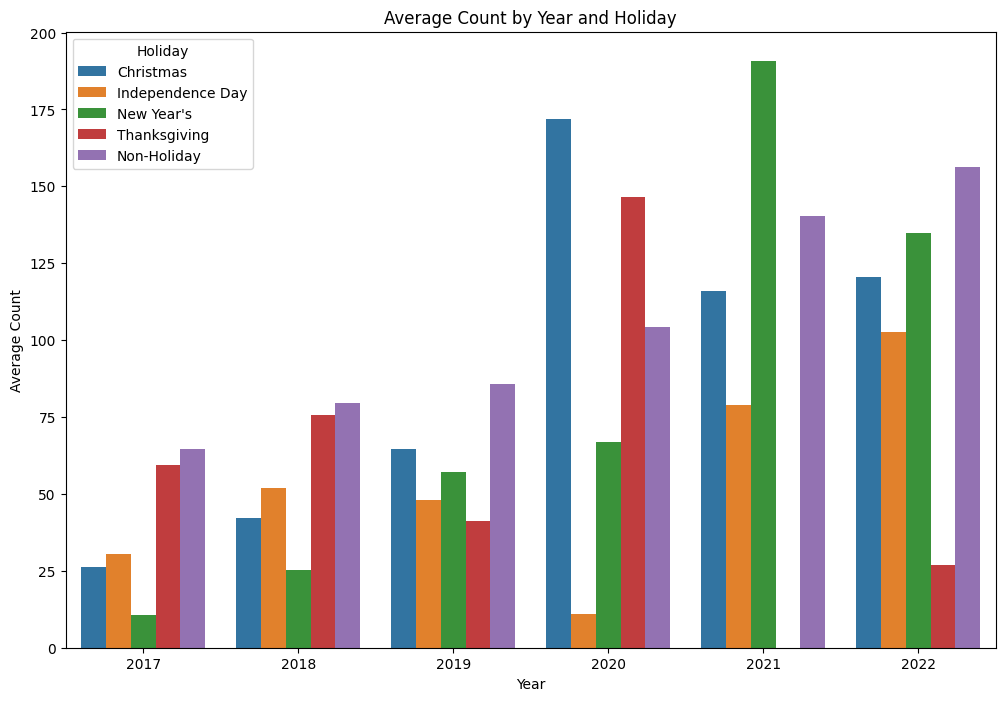

In [19]:
# Convert Avg_Count to numeric if it is not already
plot_data['Avg_Count'] = pd.to_numeric(plot_data['Avg_Count'])

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Year', y='Avg_Count', hue='Holiday', data=plot_data, errorbar=None)
plt.title('Average Count by Year and Holiday')
plt.xlabel('Year')
plt.ylabel('Average Count')
plt.legend(title='Holiday')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




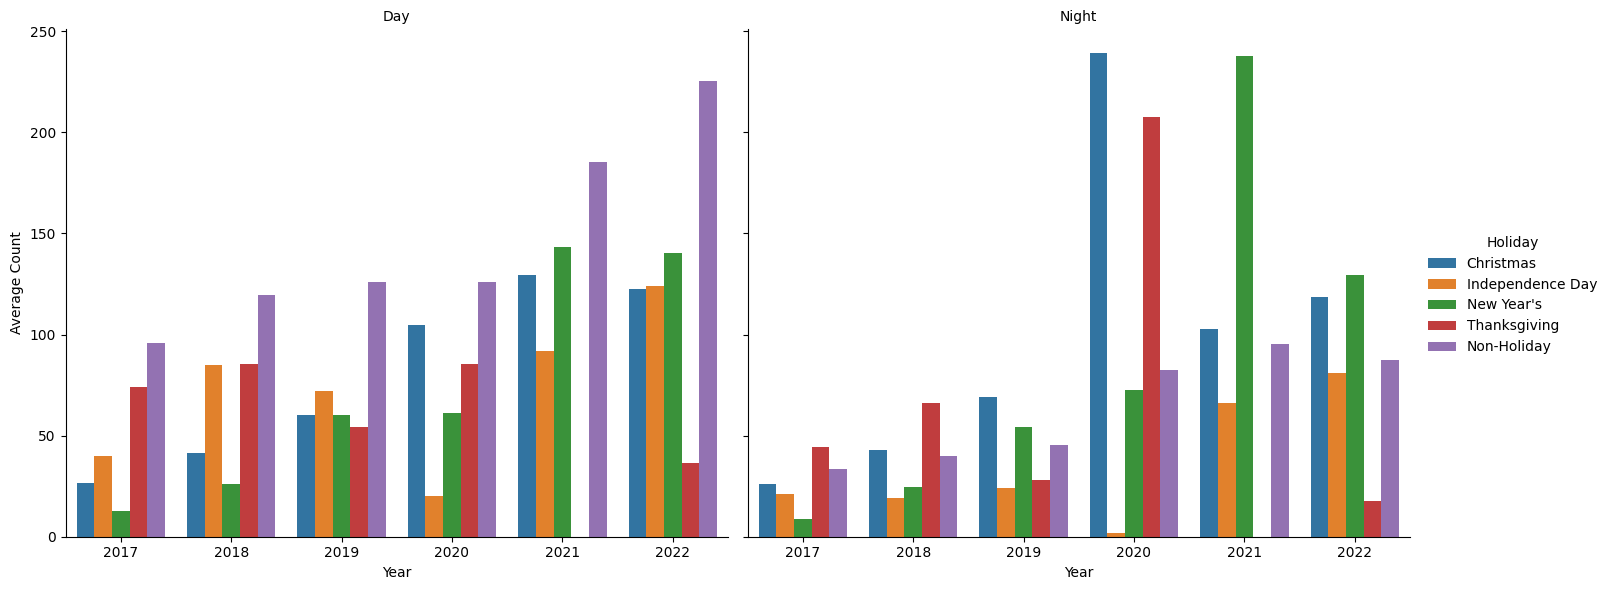

In [20]:
# Convert Avg_Count to numeric if it is not already
plot_data['Avg_Count'] = pd.to_numeric(plot_data['Avg_Count'])

# Define a custom color palette
custom_palette = {
    'Christmas': '#1f77b4',
    'Independence Day': '#ff7f0e',
    "New Year's": '#2ca02c',
    'Thanksgiving': '#d62728',
    'Non-Holiday': '#9467bd'
}

# Create a FacetGrid
g = sns.FacetGrid(plot_data, col="Sunrise_Sunset", height=6, aspect=1.2)
g.map_dataframe(sns.barplot, x='Year', y='Avg_Count', hue='Holiday', ci=None, palette=custom_palette)
g.add_legend(title='Holiday')

# Adjust the titles and layout
g.set_axis_labels("Year", "Average Count")
g.set_titles(col_template="{col_name}")

plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




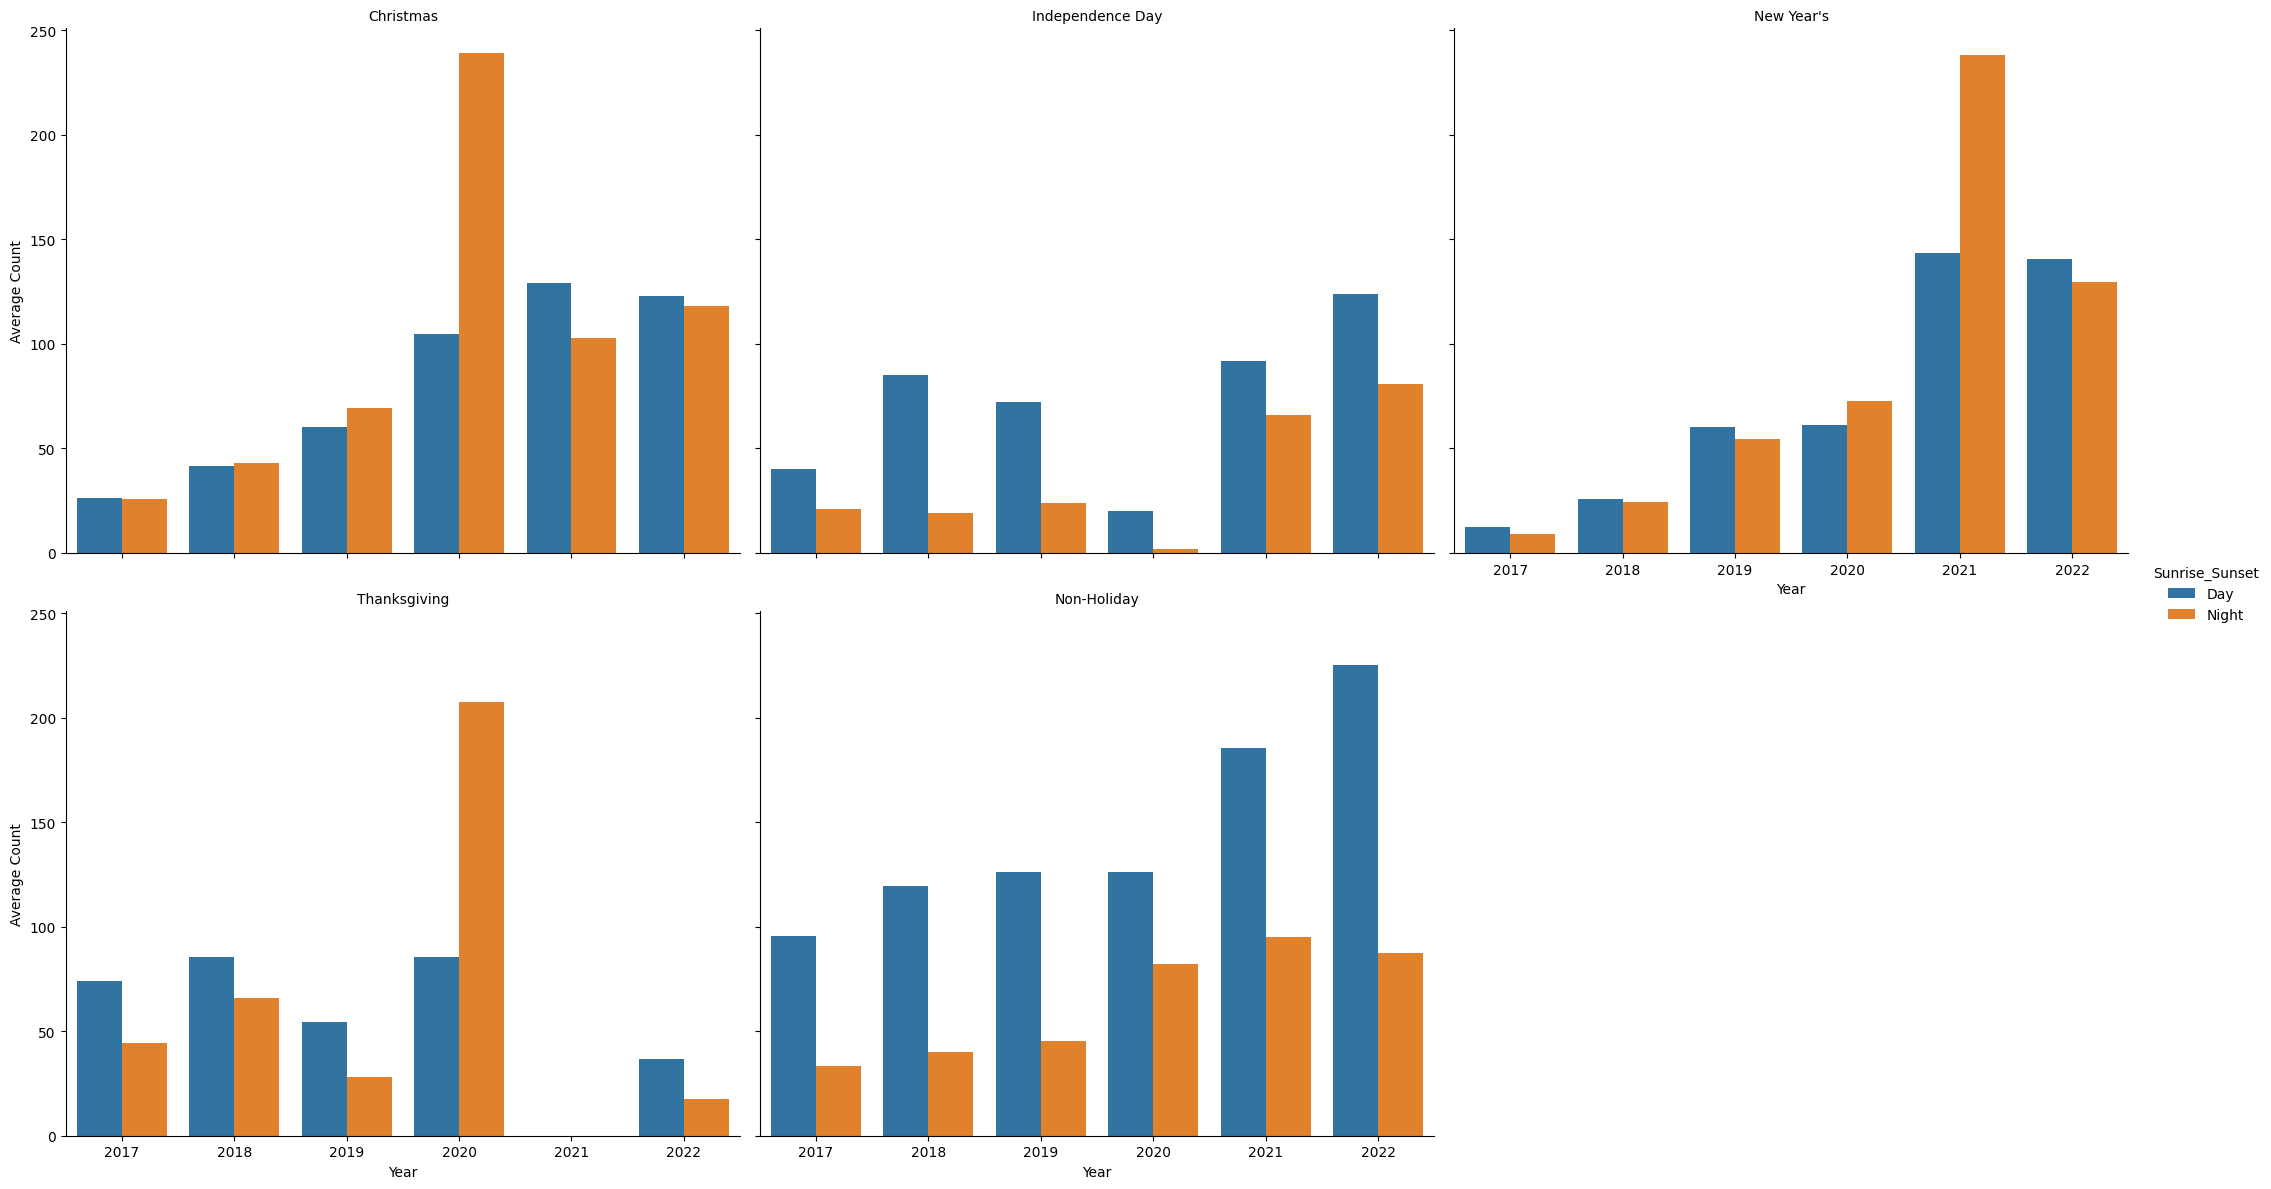

In [21]:
# Convert Avg_Count to numeric if it is not already
plot_data['Avg_Count'] = pd.to_numeric(plot_data['Avg_Count'])

# Define a custom color palette
custom_palette = {
    'Day': '#1f77b4',
    'Night': '#ff7f0e'
}

# Create a FacetGrid
g = sns.FacetGrid(plot_data, col="Holiday", height=6, aspect=1.2, col_wrap=3)
g.map_dataframe(sns.barplot, x='Year', y='Avg_Count', hue='Sunrise_Sunset', ci=None, palette=custom_palette)
g.add_legend(title='Sunrise_Sunset')

# Adjust the titles and layout
g.set_axis_labels("Year", "Average Count")
g.set_titles(col_template="{col_name}")

plt.show()

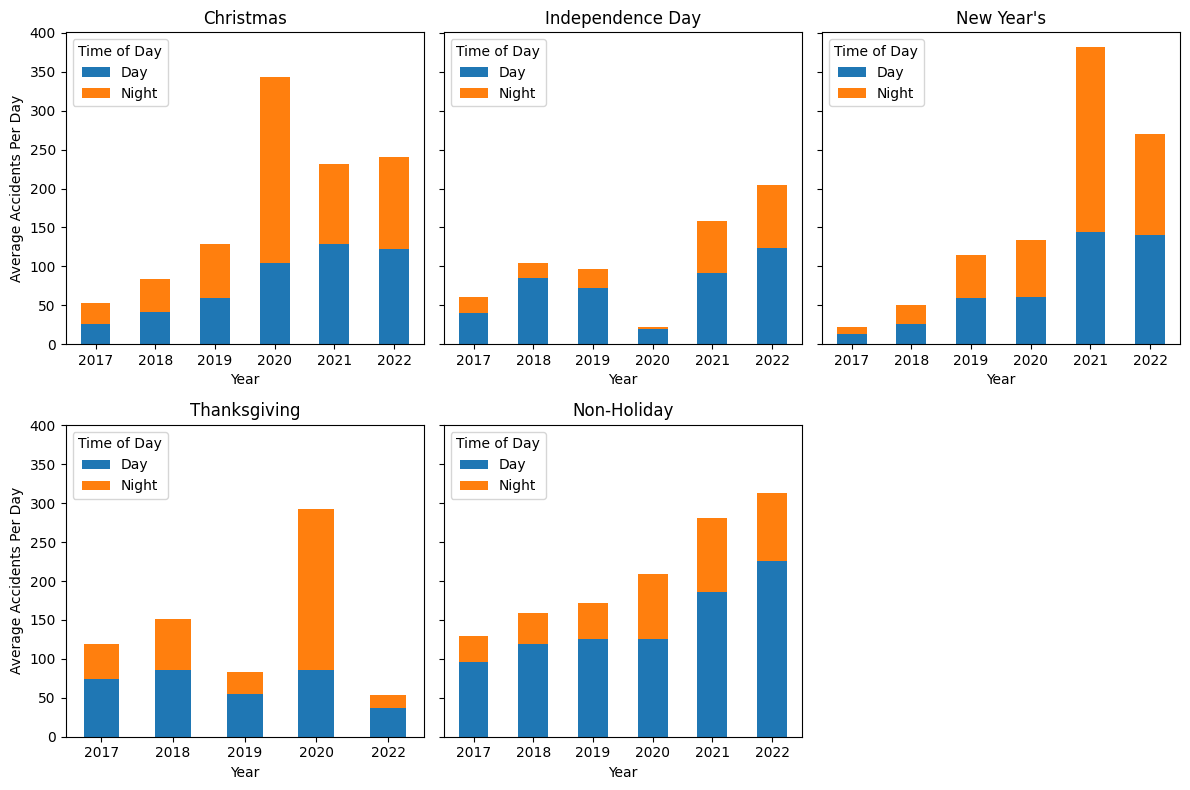

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Pivot the data to get 'Day' and 'Night' as separate columns
pivot_data = plot_data.pivot_table(index=['Year', 'Holiday'], columns='Sunrise_Sunset', values='Avg_Count', aggfunc='sum').fillna(0)

# Define holidays to ensure consistent order
holidays = plot_data['Holiday'].unique()

# Create the plot
n_holidays = len(holidays)
fig, axes = plt.subplots(nrows=(n_holidays // 3) + 1, ncols=3, figsize=(12, 8), sharey=True)
axes = axes.flatten()

for i, holiday in enumerate(holidays):
    ax = axes[i]
    subset = pivot_data.loc[pivot_data.index.get_level_values('Holiday') == holiday]
    subset.plot(kind='bar', stacked=True, ax=ax, color=['#1f77b4', '#ff7f0e'])
    ax.set_title(holiday)
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Accidents Per Day')
    ax.set_xticklabels(subset.index.get_level_values('Year'), rotation=0)
    ax.legend(title='Time of Day', loc='upper left')

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
